In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

os.chdir("/home/user/michigan/data/Ljosa-BBBC021/database")


exclude_features = ['Nuclei_Location_Center_X',
                     'Nuclei_Location_Center_Y',
                     'Cells_Location_Center_X',
                     'Cells_Location_Center_Y',
                     'Cytoplasm_Location_Center_X',
                     'Cytoplasm_Location_Center_Y']

In [3]:
def get_MOA(comp):
    return comp_moa[comp_moa["compound"]==comp]["moa"].values[0]

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def produce_result(result):
    result["correct"] = result["y"] == result["y_pred"]
    overall_acc = result["correct"].mean()
    print("overall MoA accurarcy:", overall_acc)
    print("each MoA results: ", result.groupby("y").mean())
    confu_mat = confusion_matrix(result["y"], result["y_pred"], labels = result["y"].value_counts().sort_index().index)
    plot_confusion_matrix(confu_mat,classes=result["y"].value_counts().sort_index().index)

In [309]:
GroundTruth = pd.read_csv("supplement_GroundTruth.txt", sep = "\t", names = ["compound","concentration","moa"])
comp_moa = GroundTruth.drop("concentration", axis = 1).drop_duplicates()

namelist = []
with open("supplement_Image.sql") as f:
    for i in f.readlines():
        if "NULL" in i:
            namelist.append(i.split("`")[1])
Image = pd.read_csv("supplement_Image.txt", sep = "\t", names = namelist)

namelist = []
with open("supplement_Object.sql") as f:
    for i in f.readlines():
        if "NULL" in i:
            namelist.append(i.split("`")[1])
Object = pd.read_csv("supplement_Object.txt", sep = "\t", names = namelist)



In [461]:
data = Object.merge(Image[["TableNumber","ImageNumber","Image_Metadata_Compound","Image_Metadata_Concentration"]],
                    on = ["TableNumber", "ImageNumber"], how = "right")

data = data.merge(GroundTruth[GroundTruth["compound"]!="DMSO"], 
              left_on = ["Image_Metadata_Compound","Image_Metadata_Concentration"], 
              right_on = ["compound","concentration"], how = "right")

# Mean profile

In [462]:
data = data.drop(exclude_features, axis = 1)
treatment_profile = data.groupby(["Image_Metadata_Compound","Image_Metadata_Concentration"], as_index=False).mean()
treatment_profile = treatment_profile[treatment_profile["Image_Metadata_Compound"]!="DMSO"].drop(
    ["TableNumber", "ImageNumber", "ObjectNumber"], axis=1)
X = np.array(treatment_profile.drop("Image_Metadata_Compound", axis=1))
y = np.array(treatment_profile["Image_Metadata_Compound"])

In [344]:
result = pd.DataFrame()
for i in range(len(X)):
    masked_index = y == y[i]
    X_train = X[masked_index == False]
    y_train = y[masked_index == False]
    
    X_test = X[i:(i+1)]
    y_test = y[i]

    
    neigh = KNeighborsClassifier(
    n_neighbors=1, algorithm='brute', metric='cosine')
    neigh.fit(X_train, y_train)
    
    pred = neigh.predict(X_test)
    result = result.append({"y":get_MOA(y_test),"y_pred":get_MOA(pred[0])}, ignore_index=True)


overall MoA accurarcy: 0.42718446601941745
each MoA results:                              correct
y                                  
Actin disruptors           0.000000
Aurora kinase inhibitors   0.416667
Cholesterol-lowering       0.666667
DNA damage                 0.666667
DNA replication            0.250000
Eg5 inhibitors             0.000000
Epithelial                 0.625000
Kinase inhibitors          1.000000
Microtubule destabilizers  0.642857
Microtubule stabilizers    0.222222
Protein degradation        0.285714
Protein synthesis          0.500000


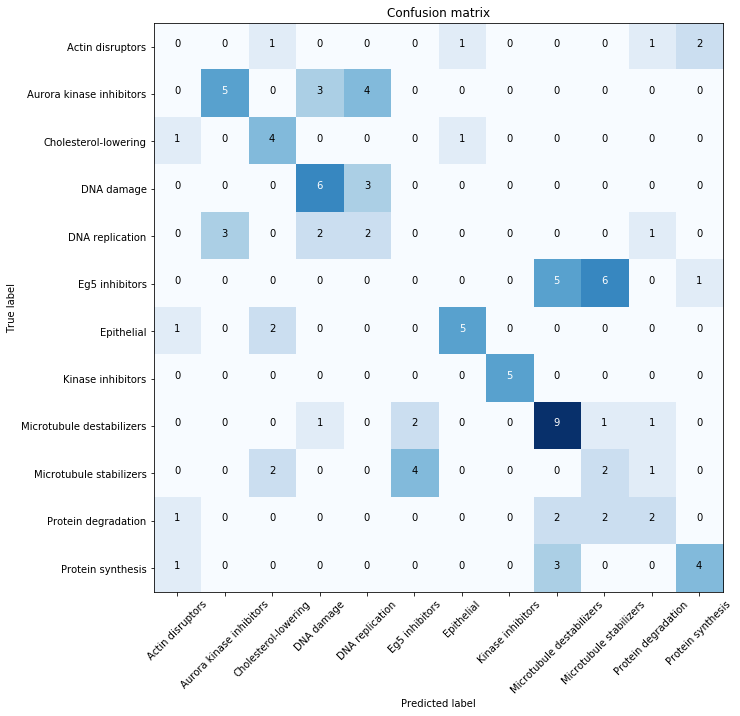

In [345]:
produce_result(result)

# DeepSet model

In [413]:
import torch
import torch.utils.data as D 
import torch.nn as nn
from modules import SAB, PMA, MAB

## Model

In [607]:
class SmallDeepSet(nn.Module):
    def __init__(self, pool="max"):
        super().__init__()
        
        self.dec = nn.Sequential(
            nn.Linear(in_features=473, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=12),
        )
        self.pool = pool

    def forward(self, x):
        if self.pool == "max":
            x = x.max(dim=1)[0]
        elif self.pool == "mean":
            x = x.mean(dim=1)
        elif self.pool == "sum":
            x = x.sum(dim=1)
        elif self.pool == "min":
            x = x.min(dim=1)[0]
        x = self.dec(x)
        return torch.softmax(x,1)


class SmallSetTransformer(nn.Module):
    def __init__(self,):
        super().__init__()

        self.dec = nn.Sequential(
            PMA(dim=473, num_heads=1, num_seeds=1),
            nn.Linear(in_features=473, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=12),
        )

    def forward(self, x):
        x = self.dec(x)
        return torch.softmax(x.squeeze(-1),2)

In [608]:
model = SmallDeepSet("max").cuda()

In [609]:
model = SmallSetTransformer().cuda()

In [561]:
profileDB[2][0].float().shape

torch.Size([87, 473])

In [565]:
model(profileDB[2][0].unsqueeze(0).cuda()).sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [523]:
torch.softmax(model(profileDB[2][0].unsqueeze(0).cuda()),1)

tensor([[4.6589e-34, 3.6454e-16, 9.8003e-37, 1.0000e+00, 3.6488e-23, 4.9629e-10,
         4.9532e-20, 0.0000e+00, 0.0000e+00, 1.7596e-36, 0.0000e+00, 0.0000e+00,
         1.1535e-27]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## data

In [467]:
class profile_DB(D.Dataset):
    def __init__(self, df):
        self.df = df
        self.meta = self.df[["TableNumber","ImageNumber"]].drop_duplicates()
        
        
    def __getitem__(self, index):
        table = self.meta.iloc[index]["TableNumber"]
        image = self.meta.iloc[index]["ImageNumber"]
        _data = self.df[(self.df["TableNumber"]==table) & (self.df["ImageNumber"]==image)]
        label = list(_data[["compound","concentration","moa"]].reset_index(drop=True).iloc[0])
        return torch.tensor(np.array(_data.drop(["Image_Metadata_Compound","Image_Metadata_Concentration",
                                         "compound","concentration","moa"], axis = 1))).float(), label
        
    def __len__(self):
        return len(self.meta)

In [468]:
profileDB = profile_DB(data)

In [469]:
loader = D.DataLoader(profileDB, batch_size=1, shuffle=False)

In [603]:
def moa_encoding(MoA):
    moa_list = list(moa["moa"].value_counts().index)
    encoding = []
    for i in range(12):
        if MoA == moa_list[i]:
            encoding.append(1)
        else:
            encoding.append(0)
    return torch.tensor(encoding).float().cuda()

In [612]:
train(model)

[0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.16662578284740448,
 0.1666599065065384,
 0.16139738261699677,
 0.12850321829319,
 0.000497318571433425,
 3.295556962257251e-05,
 2.0215486529195914e-07,
 2.7199530450161546e-06,
 3.750223687148946e-09,
 0.07341935485601425,
 0.00012257949856575578,
 5.9357263028358975e-12,
 1.5857074841954202e-16,
 5.778922361320288e-23,
 5.205328881682374e-26,
 2.2421907524149526e-27,
 1.7285653612391354e-33,
 3.9882901852921176e-35,
 0.0,
 4

In [611]:
def train(model):
    num_epochs = 1
    for epoch in range(num_epochs):
        
        model = model.cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.L1Loss().cuda()
        losses = []
        
        for i,(batch, label) in enumerate(loader):
            batch = batch.cuda()
            
            loss = criterion(model(batch), moa_encoding(label[2][0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return losses

In [218]:
meta_data = pd.read_csv("/home/user/michigan/data/BBBC021/BBBC021_v1_image.csv")
moa = pd.read_csv("/home/user/michigan/data/BBBC021/BBBC021_v1_moa.csv")
meta_data = meta_data[meta_data["Image_Metadata_Compound"] != "DMSO"]
moa = moa[moa["compound"] != "DMSO"]

In [219]:
meta_data = meta_data.merge(moa, 
              left_on = ["Image_Metadata_Compound","Image_Metadata_Concentration"], 
              right_on = ["compound","concentration"], how = "right")

In [220]:
meta_data

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,compound,concentration,moa
0,1,11,Week1_150607_B04_s3_w135D66B4C-0548-4AB8-A57B-...,Week1/Week1_22123,Week1_150607_B04_s3_w2D81AEFB9-9DD4-4B59-9177-...,Week1/Week1_22123,Week1_150607_B04_s3_w408BE006A-BF34-457E-81A9-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,cytochalasin B,10.0,Actin disruptors
1,1,12,Week1_150607_B04_s4_w1EB720AD1-83BA-48A7-8C47-...,Week1/Week1_22123,Week1_150607_B04_s4_w261B79A05-7534-46F3-8C80-...,Week1/Week1_22123,Week1_150607_B04_s4_w49FF7E7B1-F049-4994-BCA2-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,cytochalasin B,10.0,Actin disruptors
2,1,9,Week1_150607_B04_s1_w11323931B-BDA7-4F42-870E-...,Week1/Week1_22123,Week1_150607_B04_s1_w2F8F7EA7A-EC57-49CA-A556-...,Week1/Week1_22123,Week1_150607_B04_s1_w494DCA5C4-3531-497D-A8B0-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,cytochalasin B,10.0,Actin disruptors
3,1,10,Week1_150607_B04_s2_w1F649C703-6FA8-406F-8575-...,Week1/Week1_22123,Week1_150607_B04_s2_w2802CC81E-56F9-41C5-A6C2-...,Week1/Week1_22123,Week1_150607_B04_s2_w4342F300D-60F8-4256-A637-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,cytochalasin B,10.0,Actin disruptors
4,1,251,Week1_150607_B04_s3_w1B0B8AAC7-F2AD-4756-939C-...,Week1/Week1_22141,Week1_150607_B04_s3_w25C7FD77E-FDC4-471F-A512-...,Week1/Week1_22141,Week1_150607_B04_s3_w42BD03411-D32F-4179-A6C5-...,Week1/Week1_22141,Week1_22141,B04,2,cytochalasin B,10.0,cytochalasin B,10.0,Actin disruptors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2523,3,3180,Week3_290607_C06_s4_w17AB2F316-96FE-432C-9ABF-...,Week3/Week3_25701,Week3_290607_C06_s4_w21097109D-6B1F-4C5A-8524-...,Week3/Week3_25701,Week3_290607_C06_s4_w49916B999-D6D9-4F5F-A934-...,Week3/Week3_25701,Week3_25701,C06,2,emetine,1.0,emetine,1.0,Protein synthesis
2524,3,3417,Week3_290607_C06_s1_w16863C3CE-84DD-41E7-9F58-...,Week3/Week3_25721,Week3_290607_C06_s1_w2310D60E4-22D5-4B90-BDAE-...,Week3/Week3_25721,Week3_290607_C06_s1_w4BDA6E64E-196C-411B-BE46-...,Week3/Week3_25721,Week3_25721,C06,3,emetine,1.0,emetine,1.0,Protein synthesis
2525,3,3418,Week3_290607_C06_s2_w189AE7C06-F7C3-4782-AC20-...,Week3/Week3_25721,Week3_290607_C06_s2_w2D3269E69-AF4D-4F46-BA52-...,Week3/Week3_25721,Week3_290607_C06_s2_w4CE40326F-930B-4CCD-9299-...,Week3/Week3_25721,Week3_25721,C06,3,emetine,1.0,emetine,1.0,Protein synthesis
2526,3,3419,Week3_290607_C06_s3_w1F5D1CAB0-4CEB-45C4-B63D-...,Week3/Week3_25721,Week3_290607_C06_s3_w2F3F67255-B9FF-4CDD-A728-...,Week3/Week3_25721,Week3_290607_C06_s3_w451F3E9B7-356A-459E-AD69-...,Week3/Week3_25721,Week3_25721,C06,3,emetine,1.0,emetine,1.0,Protein synthesis
